In [102]:
import json
import random
import pickle
import statistics as stat
import pandas as pd
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer
from sklearn.svm import SVC,LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.base import TransformerMixin
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from sklearn.metrics import roc_auc_score,confusion_matrix,accuracy_score,f1_score,precision_score,recall_score,precision_recall_fscore_support,classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import seaborn as sns
%matplotlib inline
stopwords = stopwords.words('english')
import timeit

# Load Saved Results

In [103]:
with open('../data/gnb_devr.pickle' , 'rb') as handle: gnb_devr = pickle.load(handle)
with open('../data/gnb_devr0.pickle', 'rb') as handle: gnb_devr0 = pickle.load(handle)
with open('../data/gnb_devr1.pickle', 'rb') as handle: gnb_devr1 = pickle.load(handle)

with open('../data/gnb_testr.pickle' , 'rb') as handle: gnb_testr = pickle.load(handle)
with open('../data/gnb_testr0.pickle', 'rb') as handle: gnb_testr0 = pickle.load(handle)
with open('../data/gnb_testr1.pickle', 'rb') as handle: gnb_testr1 = pickle.load(handle)
    

with open('../data/svm_devr.pickle' , 'rb') as handle: svm_devr = pickle.load(handle)
with open('../data/svm_devr0.pickle', 'rb') as handle: svm_devr0 = pickle.load(handle)
with open('../data/svm_devr1.pickle', 'rb') as handle: svm_devr1 = pickle.load(handle)

with open('../data/svm_testr.pickle' , 'rb') as handle: svm_testr = pickle.load(handle)
with open('../data/svm_testr0.pickle', 'rb') as handle: svm_testr0 = pickle.load(handle)
with open('../data/svm_testr1.pickle', 'rb') as handle: svm_testr1 = pickle.load(handle)
    
with open('../data/mlp_mixed.pickle' , 'rb') as handle: mlp_mixed = pickle.load(handle)
with open('../data/mlp_class0.pickle', 'rb') as handle: mlp_class0 = pickle.load(handle)
with open('../data/mlp_class1.pickle', 'rb') as handle: mlp_class1 = pickle.load(handle)

In [104]:
ds = [gnb_devr,gnb_devr0,gnb_devr1,
      gnb_testr,gnb_testr0,gnb_testr1,
      svm_devr,svm_devr0,svm_devr1,
      svm_testr,svm_testr0,svm_testr1]
for d in ds:
    d['f'].insert(0,[0,0])
    d['p'].insert(0,[0,0])
    d['r'].insert(0,[0,0])

In [105]:
mlp_mixed_steps  = [0,750,1250,1750,2250,2750,3250,3500]
mlp_class0_steps = [0,500,1250,1750,2250,2723]
mlp_class1_steps = [0,200,400,600,856]

# Load Trainig Data

In [106]:
DATAPATH = "../data/ProtestNews2019/"

In [107]:
stopwords = open("../data/stopwords.txt",'r').read().split('\n\n')

In [108]:
def create_dataframe(list_of_articles):
    data = [[article['id'],article['url'],' '.join(article['text'].split('\n')),article['label']] for article in list_of_articles]
    return pd.DataFrame(data,columns=['id','url','text','label'])

In [109]:
train_data = []
with open(DATAPATH+'all_train_with_org.json', 'rb') as f:
        for line in f:
            d = json.loads(line)
            train_data.append(d)

In [110]:
train = create_dataframe(train_data)
train.label.value_counts()

0.0    2723
1.0     856
Name: label, dtype: int64

# Gaussian Results

## Mixed

### Dev

In [111]:
mix_steps  =  list(range(round(train.shape[0]/10),
                     train.shape[0],
                     round(train.shape[0]/10)))
mix_steps.append(train.shape[0])
mix_steps.insert(0,0)

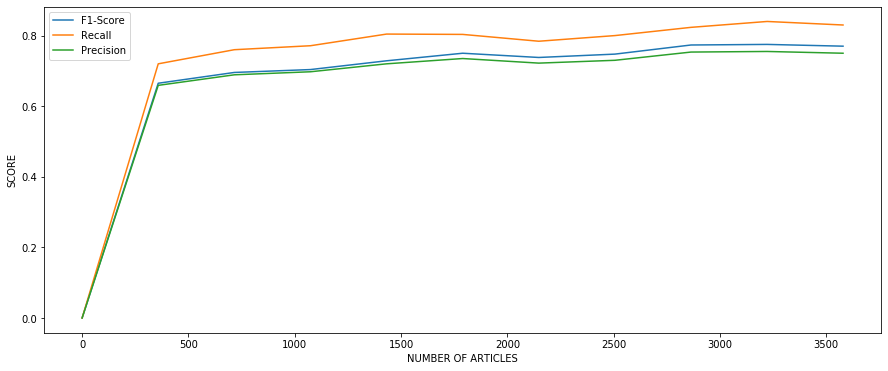

In [112]:
plt.figure(figsize=(15,6))
plt.plot(mix_steps,[stat.mean(i) for i in gnb_devr['f']],label="F1-Score")
plt.plot(mix_steps,[stat.mean(i) for i in gnb_devr['r']],label="Recall")
plt.plot(mix_steps,[stat.mean(i) for i in gnb_devr['p']],label="Precision")
plt.ylabel('SCORE')
plt.xlabel('NUMBER OF ARTICLES')
plt.legend()
plt.show()

In [113]:
gnb_devr['p'][-1].append(gnb_devr['p'][-1][0])
gnb_devr['f'][-1].append(gnb_devr['f'][-1][0])
gnb_devr['r'][-1].append(gnb_devr['r'][-1][0])

In [114]:
pd.DataFrame([[mix_steps[s],stat.mean(gnb_devr['f'][s]),
 stat.stdev(gnb_devr['f'][s])] 
 for s in range(len(gnb_devr['f']))],columns=['Sample Size','Avg F1-Score','F1-Score Std Dev.'])

,Sample Size,Avg F1-Score,F1-Score Std Dev.
0,0,0.000000,0.000000
1,358,0.665000,0.034721
2,716,0.695556,0.024037
3,1074,0.703750,0.016850
4,1432,0.728571,0.025448
5,1790,0.750000,0.014142
6,2148,0.738000,0.019235
7,2506,0.747500,0.012583
8,2864,0.773333,0.005774
9,3222,0.775000,0.007071


In [115]:
pd.DataFrame([[mix_steps[s],stat.mean(gnb_devr['p'][s]),
 stat.stdev(gnb_devr['p'][s])] 
 for s in range(len(gnb_devr['p']))],columns=['Sample Size','Avg Precision','Precision Std Dev.'])

,Sample Size,Avg Precision,Precision Std Dev.
0,0,0.000000,0.000000
1,358,0.659000,0.030350
2,716,0.688889,0.019003
3,1074,0.697500,0.013887
4,1432,0.720000,0.016330
5,1790,0.735000,0.010488
6,2148,0.722000,0.016432
7,2506,0.730000,0.014142
8,2864,0.753333,0.005774
9,3222,0.755000,0.007071


In [116]:
pd.DataFrame([[mix_steps[s],stat.mean(gnb_devr['r'][s]),
 stat.stdev(gnb_devr['r'][s])] 
 for s in range(len(gnb_devr['r']))],columns=['Sample Size','Avg F1-Score','F1-Score Std Dev.'])

,Sample Size,Avg F1-Score,F1-Score Std Dev.
0,0,0.000000,0.000000
1,358,0.720000,0.041633
2,716,0.760000,0.020616
3,1074,0.771250,0.015526
4,1432,0.804286,0.017182
5,1790,0.803333,0.019664
6,2148,0.784000,0.018166
7,2506,0.800000,0.014142
8,2864,0.823333,0.005774
9,3222,0.840000,0.014142


### Test

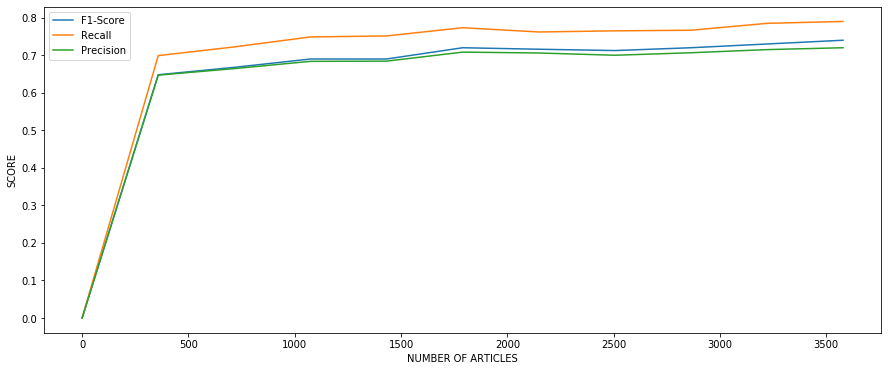

In [117]:
plt.plot(mix_steps,[stat.mean(i) for i in gnb_testr['f']],label="F1-Score") 
plt.plot(mix_steps,[stat.mean(i) for i in gnb_testr['r']],label="Recall")     
plt.plot(mix_steps,[stat.mean(i) for i in gnb_testr['p']],label="Precision")
plt.figure(figsize=(15,6))
plt.ylabel('SCORE')
plt.xlabel('NUMBER OF ARTICLES')
plt.legend()
plt.show()

In [118]:
gnb_testr['p'][-1].append(gnb_testr['p'][-1][0])
gnb_testr['f'][-1].append(gnb_testr['f'][-1][0])
gnb_testr['r'][-1].append(gnb_testr['r'][-1][0])

In [119]:
pd.DataFrame([[mix_steps[s],stat.mean(gnb_testr['f'][s]),
 stat.stdev(gnb_testr['f'][s])] 
 for s in range(len(gnb_testr['f']))],columns=['Sample Size','Avg F1-Score','F1-Score Std Dev.'])

,Sample Size,Avg F1-Score,F1-Score Std Dev.
0,0,0.000000,0.000000
1,358,0.648000,0.045412
2,716,0.667778,0.016415
3,1074,0.690000,0.019272
4,1432,0.690000,0.025166
5,1790,0.720000,0.010954
6,2148,0.716000,0.011402
7,2506,0.712500,0.005000
8,2864,0.720000,0.000000
9,3222,0.730000,0.000000


In [120]:
pd.DataFrame([[mix_steps[s],stat.mean(gnb_testr['p'][s]),
 stat.stdev(gnb_testr['p'][s])] 
 for s in range(len(gnb_testr['p']))],columns=['Sample Size','Avg Precision','Precision Std Dev.'])

,Sample Size,Avg Precision,Precision Std Dev.
0,0,0.000000,0.000000
1,358,0.647000,0.041110
2,716,0.664444,0.017401
3,1074,0.683750,0.015059
4,1432,0.684286,0.015119
5,1790,0.708333,0.009832
6,2148,0.706000,0.011402
7,2506,0.700000,0.008165
8,2864,0.706667,0.005774
9,3222,0.715000,0.007071


In [121]:
pd.DataFrame([[mix_steps[s],stat.mean(gnb_testr['r'][s]),
 stat.stdev(gnb_testr['r'][s])] 
 for s in range(len(gnb_testr['r']))],columns=['Sample Size','Avg Recall','Recall Std Dev.'])

,Sample Size,Avg Recall,Recall Std Dev.
0,0,0.000000,0.000000
1,358,0.699000,0.053009
2,716,0.722222,0.022791
3,1074,0.748750,0.018851
4,1432,0.751429,0.016762
5,1790,0.773333,0.008165
6,2148,0.762000,0.016432
7,2506,0.765000,0.010000
8,2864,0.766667,0.005774
9,3222,0.785000,0.007071


## Class 0

### Dev

In [122]:
cls0_steps = list(range(round(train[train.label == 0.0].shape[0]/10),
                   train[train.label == 0.0].shape[0],
                   round(train[train.label == 0.0].shape[0]/10)))
cls0_steps.insert(0,0)

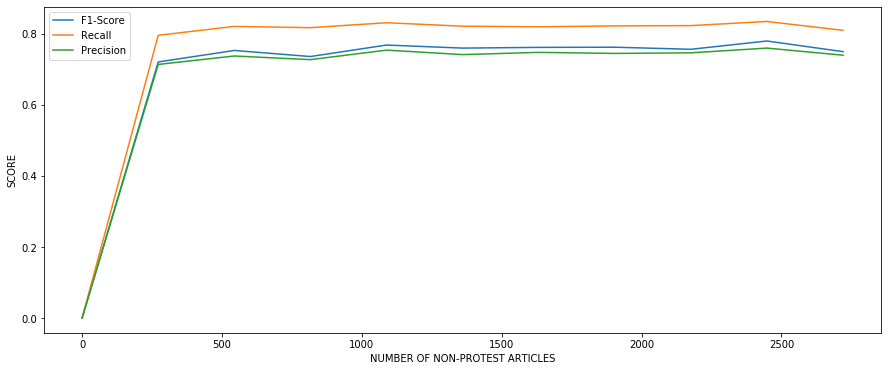

In [123]:
plt.figure(figsize=(15,6))
plt.plot(cls0_steps,[stat.mean(i) for i in gnb_devr0['f']],label="F1-Score")
plt.plot(cls0_steps,[stat.mean(i) for i in gnb_devr0['r']],label="Recall")
plt.plot(cls0_steps,[stat.mean(i) for i in gnb_devr0['p']],label="Precision")
plt.ylabel('SCORE')
plt.xlabel('NUMBER OF NON-PROTEST ARTICLES')
plt.legend()
plt.show()

In [124]:
gnb_devr0['p'][-1].append(gnb_devr0['p'][-1][0])
gnb_devr0['f'][-1].append(gnb_devr0['f'][-1][0])
gnb_devr0['r'][-1].append(gnb_devr0['r'][-1][0])

In [125]:
pd.DataFrame([[cls0_steps[s],stat.mean(gnb_devr0['f'][s]),
 stat.stdev(gnb_devr0['f'][s])] 
 for s in range(len(gnb_devr0['f']))],columns=['Sample Size','Avg F1-Score','F1-Score Std Dev.'])

,Sample Size,Avg F1-Score,F1-Score Std Dev.
0,0,0.000000,0.000000
1,272,0.721000,0.014491
2,544,0.753333,0.016583
3,816,0.736250,0.017678
4,1088,0.768571,0.019518
5,1360,0.760000,0.012649
6,1632,0.762000,0.016432
7,1904,0.762500,0.009574
8,2176,0.756667,0.023094
9,2448,0.780000,0.000000


In [126]:
pd.DataFrame([[cls0_steps[s],stat.mean(gnb_devr0['p'][s]),
 stat.stdev(gnb_devr0['p'][s])] 
 for s in range(len(gnb_devr0['p']))],columns=['Sample Size','Avg Precision','Precision Std Dev.'])

,Sample Size,Avg Precision,Precision Std Dev.
0,0,0.000000,0.000000
1,272,0.714000,0.010750
2,544,0.737778,0.012019
3,816,0.727500,0.010351
4,1088,0.754286,0.015119
5,1360,0.741667,0.009832
6,1632,0.748000,0.014832
7,1904,0.745000,0.005774
8,2176,0.746667,0.015275
9,2448,0.760000,0.000000


In [127]:
pd.DataFrame([[cls0_steps[s],stat.mean(gnb_devr0['r'][s]),
 stat.stdev(gnb_devr0['r'][s])] 
 for s in range(len(gnb_devr0['r']))],columns=['Sample Size','Avg Recall','Recall Std Dev.'])

,Sample Size,Avg Recall,Recall Std Dev.
0,0,0.000000,0.000000
1,272,0.796000,0.012649
2,544,0.821111,0.010541
3,816,0.817500,0.012817
4,1088,0.831429,0.020354
5,1360,0.821667,0.014720
6,1632,0.820000,0.012247
7,1904,0.822500,0.009574
8,2176,0.823333,0.011547
9,2448,0.835000,0.007071


### Test

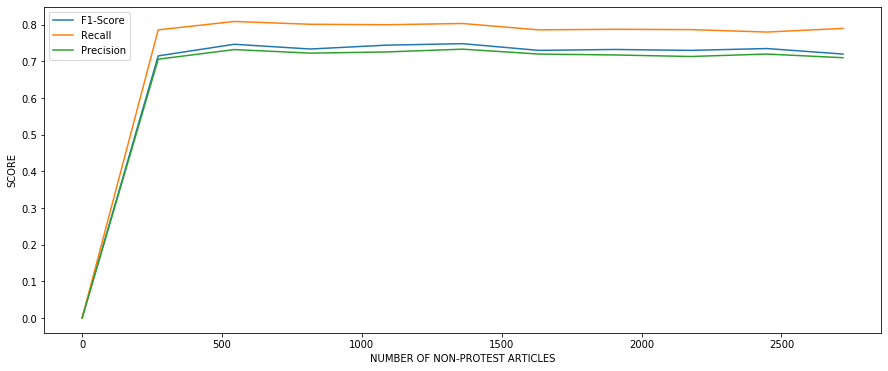

In [128]:
plt.figure(figsize=(15,6))
plt.plot(cls0_steps,[stat.mean(i) for i in gnb_testr0['f']],label="F1-Score")
plt.plot(cls0_steps,[stat.mean(i) for i in gnb_testr0['r']],label="Recall")
plt.plot(cls0_steps,[stat.mean(i) for i in gnb_testr0['p']],label="Precision")
plt.ylabel('SCORE')
plt.xlabel('NUMBER OF NON-PROTEST ARTICLES')
plt.legend()
plt.show()

In [129]:
gnb_testr0['p'][-1].append(gnb_testr0['p'][-1][0])
gnb_testr0['f'][-1].append(gnb_testr0['f'][-1][0])
gnb_testr0['r'][-1].append(gnb_testr0['r'][-1][0])

In [130]:
pd.DataFrame([[cls0_steps[s],stat.mean(gnb_testr0['f'][s]),
 stat.stdev(gnb_testr0['f'][s])] 
 for s in range(len(gnb_testr0['f']))],columns=['Sample Size','Avg F1-Score','F1-Score Std Dev.'])

,Sample Size,Avg F1-Score,F1-Score Std Dev.
0,0,0.000000,0.000000
1,272,0.715000,0.010801
2,544,0.746667,0.019365
3,816,0.733750,0.007440
4,1088,0.744286,0.013973
5,1360,0.748333,0.014720
6,1632,0.730000,0.007071
7,1904,0.732500,0.017078
8,2176,0.730000,0.010000
9,2448,0.735000,0.007071


In [131]:
pd.DataFrame([[cls0_steps[s],stat.mean(gnb_testr0['p'][s]),
 stat.stdev(gnb_testr0['p'][s])] 
 for s in range(len(gnb_testr0['p']))],columns=['Sample Size','Avg Precision','Precision Std Dev.'])

,Sample Size,Avg Precision,Precision Std Dev.
0,0,0.000000,0.000000
1,272,0.706000,0.010750
2,544,0.732222,0.013944
3,816,0.722500,0.007071
4,1088,0.725714,0.012724
5,1360,0.733333,0.010328
6,1632,0.720000,0.007071
7,1904,0.717500,0.015000
8,2176,0.713333,0.005774
9,2448,0.720000,0.000000


In [132]:
pd.DataFrame([[cls0_steps[s],stat.mean(gnb_testr0['r'][s]),
 stat.stdev(gnb_testr0['r'][s])] 
 for s in range(len(gnb_testr0['r']))],columns=['Sample Size','Avg Recall','Recall Std Dev.'])

,Sample Size,Avg Recall,Recall Std Dev.
0,0,0.000000,0.000000
1,272,0.786000,0.014298
2,544,0.808889,0.012693
3,816,0.801250,0.009910
4,1088,0.800000,0.015275
5,1360,0.803333,0.015055
6,1632,0.786000,0.005477
7,1904,0.787500,0.015000
8,2176,0.786667,0.005774
9,2448,0.780000,0.000000


## Class 1

### Dev

In [133]:
cls1_steps = list(range(round(train[train.label == 1.0].shape[0]/10),
                   train[train.label == 1.0].shape[0],
                   round(train[train.label == 1.0].shape[0]/10)))
cls1_steps.append(train[train.label == 1.0].shape[0])
cls1_steps.insert(0,0)

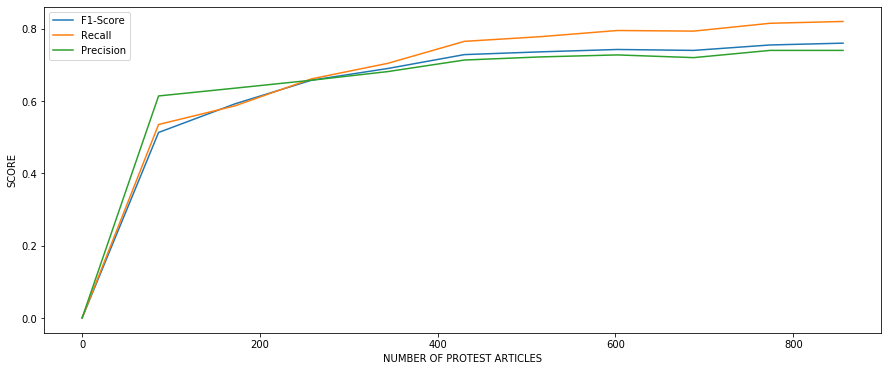

In [134]:
plt.figure(figsize=(15,6))
plt.plot(cls1_steps,[stat.mean(i) for i in gnb_devr1['f']],label="F1-Score")
plt.plot(cls1_steps,[stat.mean(i) for i in gnb_devr1['r']],label="Recall")
plt.plot(cls1_steps,[stat.mean(i) for i in gnb_devr1['p']],label="Precision")
plt.ylabel('SCORE')
plt.xlabel('NUMBER OF PROTEST ARTICLES')
plt.legend()
plt.show()

In [135]:
gnb_devr1['p'][-1].append(gnb_devr1['p'][-1][0])
gnb_devr1['f'][-1].append(gnb_devr1['f'][-1][0])
gnb_devr1['r'][-1].append(gnb_devr1['r'][-1][0])

In [136]:
pd.DataFrame([[cls1_steps[s],stat.mean(gnb_devr1['f'][s]),
 stat.stdev(gnb_devr1['f'][s])] 
 for s in range(len(gnb_devr1['f']))],columns=['Sample Size','Avg. F1-Score','F1-Score Std Dev.'])

,Sample Size,Avg. F1-Score,F1-Score Std Dev.
0,0,0.000000,0.000000
1,86,0.513000,0.054171
2,172,0.592222,0.030322
3,258,0.657500,0.021213
4,344,0.690000,0.018257
5,430,0.728333,0.026394
6,516,0.736000,0.011402
7,602,0.742500,0.012583
8,688,0.740000,0.010000
9,774,0.755000,0.007071


In [137]:
pd.DataFrame([[cls1_steps[s],stat.mean(gnb_devr1['p'][s]),
 stat.stdev(gnb_devr1['p'][s])] 
 for s in range(len(gnb_devr1['p']))],columns=['Sample Size','Avg. Precision','Precision Std Dev.'])

,Sample Size,Avg. Precision,Precision Std Dev.
0,0,0.000000,0.000000
1,86,0.614000,0.052536
2,172,0.635556,0.033582
3,258,0.657500,0.012817
4,344,0.681429,0.017728
5,430,0.713333,0.025033
6,516,0.722000,0.008367
7,602,0.727500,0.015000
8,688,0.720000,0.010000
9,774,0.740000,0.014142


In [138]:
pd.DataFrame([[cls1_steps[s],stat.mean(gnb_devr1['r'][s]),
 stat.stdev(gnb_devr1['r'][s])] 
 for s in range(len(gnb_devr1['r']))],columns=['Sample Size','Avg. Recall','Recall Std Dev.'])

,Sample Size,Avg. Recall,Recall Std Dev.
0,0,0.000000,0.000000
1,86,0.535000,0.034400
2,172,0.586667,0.025981
3,258,0.661250,0.031820
4,344,0.704286,0.017182
5,430,0.765000,0.038341
6,516,0.778000,0.010954
7,602,0.795000,0.023805
8,688,0.793333,0.015275
9,774,0.815000,0.007071


### Test

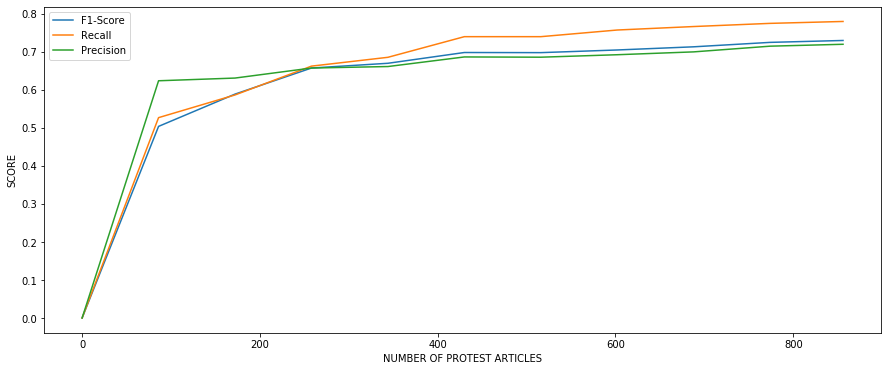

In [139]:
plt.figure(figsize=(15,6))
plt.plot(cls1_steps,[stat.mean(i) for i in gnb_testr1['f']],label="F1-Score")
plt.plot(cls1_steps,[stat.mean(i) for i in gnb_testr1['r']],label="Recall")
plt.plot(cls1_steps,[stat.mean(i) for i in gnb_testr1['p']],label="Precision")
plt.ylabel('SCORE')
plt.xlabel('NUMBER OF PROTEST ARTICLES')
plt.legend()
plt.show()

In [140]:
gnb_testr1['p'][-1].append(gnb_testr1['p'][-1][0])
gnb_testr1['f'][-1].append(gnb_testr1['f'][-1][0])
gnb_testr1['r'][-1].append(gnb_testr1['r'][-1][0])

In [141]:
pd.DataFrame([[cls1_steps[s],stat.mean(gnb_testr1['f'][s]),
 stat.stdev(gnb_testr1['f'][s])] 
 for s in range(len(gnb_testr1['f']))],columns=['Sample Size','Avg. F1-Score','F1-Score Std Dev.'])

,Sample Size,Avg. F1-Score,F1-Score Std Dev.
0,0,0.000000,0.000000
1,86,0.504000,0.034383
2,172,0.588889,0.028038
3,258,0.657500,0.019086
4,344,0.670000,0.012910
5,430,0.698333,0.026394
6,516,0.698000,0.008367
7,602,0.705000,0.005774
8,688,0.713333,0.015275
9,774,0.725000,0.007071


In [142]:
pd.DataFrame([[cls1_steps[s],stat.mean(gnb_testr1['p'][s]),
 stat.stdev(gnb_testr1['p'][s])] 
 for s in range(len(gnb_testr1['p']))],columns=['Sample Size','Avg. Precision','Precision Std Dev.'])

,Sample Size,Avg. Precision,Precision Std Dev.
0,0,0.000000,0.000000
1,86,0.624000,0.055418
2,172,0.631111,0.012693
3,258,0.657500,0.015811
4,344,0.661429,0.012150
5,430,0.686667,0.025033
6,516,0.686000,0.005477
7,602,0.692500,0.009574
8,688,0.700000,0.010000
9,774,0.715000,0.007071


In [143]:
pd.DataFrame([[cls1_steps[s],stat.mean(gnb_testr1['r'][s]),
 stat.stdev(gnb_testr1['r'][s])] 
 for s in range(len(gnb_testr1['r']))],columns=['Sample Size','Avg. Recall','Recall Std Dev.'])

,Sample Size,Avg. Recall,Recall Std Dev.
0,0,0.000000,0.000000
1,86,0.527000,0.016364
2,172,0.586667,0.032016
3,258,0.662500,0.031510
4,344,0.685714,0.016183
5,430,0.740000,0.036332
6,516,0.740000,0.007071
7,602,0.757500,0.012583
8,688,0.766667,0.015275
9,774,0.775000,0.007071


# SVM Results

## Mixed

### Dev

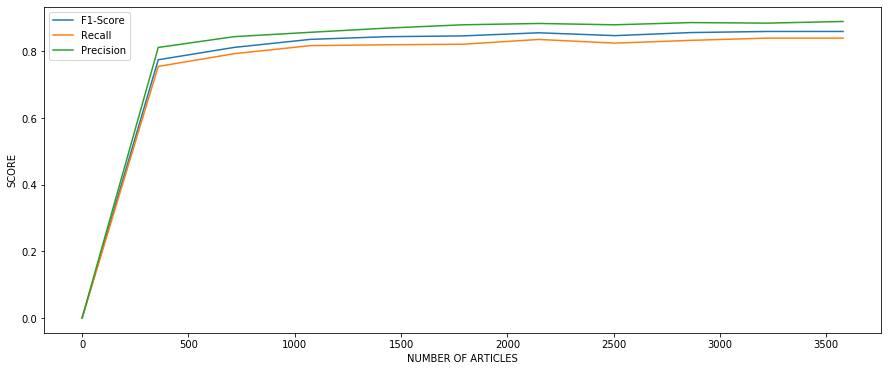

In [144]:
plt.figure(figsize=(15,6))
plt.plot(mix_steps,[stat.mean(i) for i in svm_devr['f']],label="F1-Score")
plt.plot(mix_steps,[stat.mean(i) for i in svm_devr['r']],label="Recall")
plt.plot(mix_steps,[stat.mean(i) for i in svm_devr['p']],label="Precision")
plt.ylabel('SCORE')
plt.xlabel('NUMBER OF ARTICLES')
plt.legend()
plt.show()

In [145]:
svm_devr['p'][-1].append(svm_devr['p'][-1][0])
svm_devr['f'][-1].append(svm_devr['f'][-1][0])
svm_devr['r'][-1].append(svm_devr['r'][-1][0])

In [146]:
pd.DataFrame([[mix_steps[s],stat.mean(svm_devr['f'][s]),
 stat.stdev(svm_devr['f'][s])] 
 for s in range(len(svm_devr['f']))],columns=['Sample Size','Avg F1-Score','F1-Score Std Dev.'])

,Sample Size,Avg F1-Score,F1-Score Std Dev.
0,0,0.000000,0.000000
1,358,0.775000,0.026771
2,716,0.812222,0.019221
3,1074,0.836250,0.013025
4,1432,0.844286,0.005345
5,1790,0.846667,0.015055
6,2148,0.856000,0.005477
7,2506,0.847500,0.015000
8,2864,0.856667,0.005774
9,3222,0.860000,0.014142


In [147]:
pd.DataFrame([[mix_steps[s],stat.mean(svm_devr['p'][s]),
 stat.stdev(svm_devr['p'][s])] 
 for s in range(len(svm_devr['p']))],columns=['Sample Size','Avg. Precision','Precision Std Dev.'])

,Sample Size,Avg. Precision,Precision Std Dev.
0,0,0.000000,0.000000
1,358,0.812000,0.035528
2,716,0.844444,0.026034
3,1074,0.857500,0.018323
4,1432,0.870000,0.008165
5,1790,0.880000,0.017889
6,2148,0.884000,0.015166
7,2506,0.880000,0.014142
8,2864,0.886667,0.005774
9,3222,0.885000,0.007071


In [148]:
pd.DataFrame([[mix_steps[s],stat.mean(svm_devr['r'][s]),
 stat.stdev(svm_devr['r'][s])] 
 for s in range(len(svm_devr['r']))],columns=['Sample Size','Avg. Recall','Recall Std Dev.'])

,Sample Size,Avg. Recall,Recall Std Dev.
0,0,0.000000,0.000000
1,358,0.755000,0.028771
2,716,0.793333,0.019365
3,1074,0.817500,0.010351
4,1432,0.820000,0.005774
5,1790,0.821667,0.017224
6,2148,0.836000,0.005477
7,2506,0.825000,0.012910
8,2864,0.833333,0.005774
9,3222,0.840000,0.014142


### Test

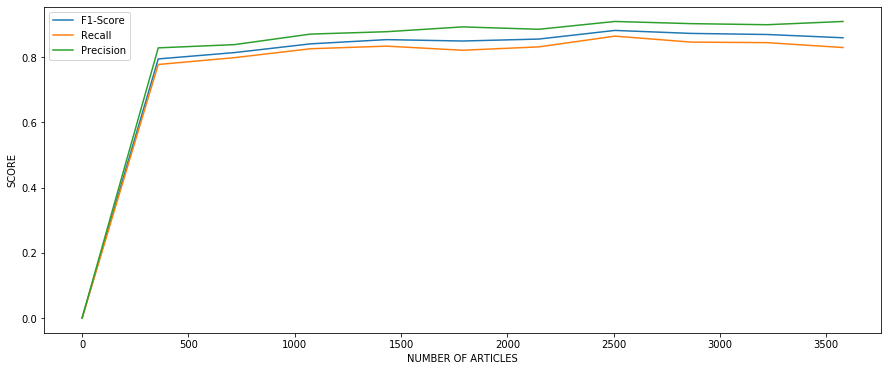

In [149]:
plt.figure(figsize=(15,6))
plt.plot(mix_steps,[stat.mean(i) for i in svm_testr['f']],label="F1-Score")
plt.plot(mix_steps,[stat.mean(i) for i in svm_testr['r']],label="Recall")
plt.plot(mix_steps,[stat.mean(i) for i in svm_testr['p']],label="Precision")
plt.ylabel('SCORE')
plt.xlabel('NUMBER OF ARTICLES')
plt.legend()
plt.show()

In [150]:
svm_testr['p'][-1].append(svm_testr['p'][-1][0])
svm_testr['f'][-1].append(svm_testr['f'][-1][0])
svm_testr['r'][-1].append(svm_testr['r'][-1][0])

In [151]:
pd.DataFrame([[mix_steps[s],stat.mean(svm_testr['f'][s]),
 stat.stdev(svm_testr['f'][s])] 
 for s in range(len(svm_testr['f']))],columns=['Sample Size','Avg F1-Score','F1-Score Std Dev.'])

,Sample Size,Avg F1-Score,F1-Score Std Dev.
0,0,0.000000,0.000000
1,358,0.795000,0.027588
2,716,0.814444,0.035395
3,1074,0.841250,0.030443
4,1432,0.854286,0.013973
5,1790,0.850000,0.010954
6,2148,0.856000,0.018166
7,2506,0.882500,0.009574
8,2864,0.873333,0.005774
9,3222,0.870000,0.028284


In [152]:
pd.DataFrame([[mix_steps[s],stat.mean(svm_testr['p'][s]),
 stat.stdev(svm_testr['p'][s])] 
 for s in range(len(svm_testr['p']))],columns=['Sample Size','Avg. Precision','Precision Std Dev.'])

,Sample Size,Avg. Precision,Precision Std Dev.
0,0,0.000000,0.000000
1,358,0.829000,0.035103
2,716,0.838889,0.038873
3,1074,0.871250,0.026424
4,1432,0.878571,0.016762
5,1790,0.893333,0.010328
6,2148,0.886000,0.024083
7,2506,0.910000,0.011547
8,2864,0.903333,0.005774
9,3222,0.900000,0.028284


In [153]:
pd.DataFrame([[mix_steps[s],stat.mean(svm_testr['r'][s]),
 stat.stdev(svm_testr['r'][s])] 
 for s in range(len(svm_testr['r']))],columns=['Sample Size','Avg. Recall','Recall Std Dev.'])

,Sample Size,Avg. Recall,Recall Std Dev.
0,0,0.000000,0.000000
1,358,0.778000,0.034577
2,716,0.798889,0.033706
3,1074,0.826250,0.033354
4,1432,0.834286,0.022254
5,1790,0.821667,0.017224
6,2148,0.832000,0.019235
7,2506,0.865000,0.005774
8,2864,0.846667,0.011547
9,3222,0.845000,0.035355


## Class 0

### Dev

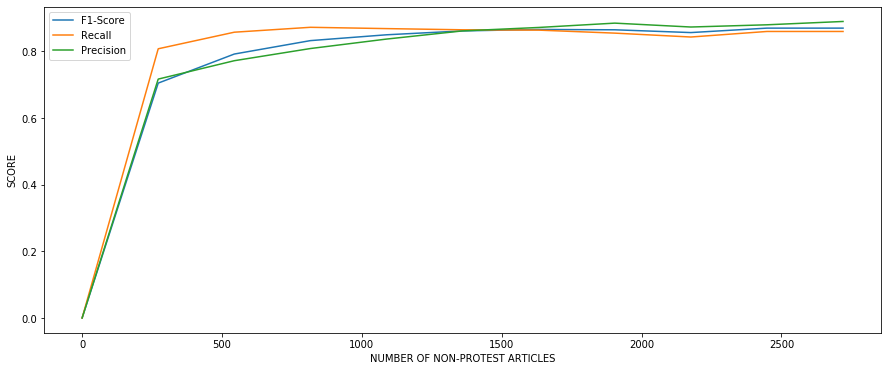

In [154]:
plt.figure(figsize=(15,6))
plt.plot(cls0_steps,[stat.mean(i) for i in svm_devr0['f']],label="F1-Score")
plt.plot(cls0_steps,[stat.mean(i) for i in svm_devr0['r']],label="Recall")
plt.plot(cls0_steps,[stat.mean(i) for i in svm_devr0['p']],label="Precision")
plt.ylabel('SCORE')
plt.xlabel('NUMBER OF NON-PROTEST ARTICLES')
plt.legend()
plt.show()

In [155]:
svm_devr0['p'][-1].append(svm_devr0['p'][-1][0])
svm_devr0['f'][-1].append(svm_devr0['f'][-1][0])
svm_devr0['r'][-1].append(svm_devr0['r'][-1][0])

In [156]:
pd.DataFrame([[cls0_steps[s],stat.mean(svm_devr0['f'][s]),
 stat.stdev(svm_devr0['f'][s])] 
 for s in range(len(svm_devr0['f']))],columns=['Sample Size','Avg F1-Score','F1-Score Std Dev.'])

,Sample Size,Avg F1-Score,F1-Score Std Dev.
0,0,0.000000,0.000000
1,272,0.705000,0.026771
2,544,0.792222,0.021082
3,816,0.832500,0.007071
4,1088,0.850000,0.008165
5,1360,0.861667,0.009832
6,1632,0.866000,0.011402
7,1904,0.865000,0.005774
8,2176,0.856667,0.011547
9,2448,0.870000,0.000000


In [157]:
pd.DataFrame([[cls0_steps[s],stat.mean(svm_devr0['p'][s]),
 stat.stdev(svm_devr0['p'][s])] 
 for s in range(len(svm_devr0['p']))],columns=['Sample Size','Avg. Precision','Precision Std Dev.'])

,Sample Size,Avg. Precision,Precision Std Dev.
0,0,0.000000,0.000000
1,272,0.717000,0.013375
2,544,0.772222,0.014814
3,816,0.808750,0.006409
4,1088,0.837143,0.004880
5,1360,0.861667,0.009832
6,1632,0.872000,0.019235
7,1904,0.885000,0.010000
8,2176,0.873333,0.011547
9,2448,0.880000,0.000000


In [158]:
pd.DataFrame([[cls0_steps[s],stat.mean(svm_devr0['r'][s]),
 stat.stdev(svm_devr0['r'][s])] 
 for s in range(len(svm_devr0['r']))],columns=['Sample Size','Avg. Recall','Recall Std Dev.'])

,Sample Size,Avg. Recall,Recall Std Dev.
0,0,0.000000,0.000000
1,272,0.808000,0.016865
2,544,0.857778,0.012019
3,816,0.872500,0.007071
4,1088,0.868571,0.010690
5,1360,0.865000,0.005477
6,1632,0.864000,0.008944
7,1904,0.855000,0.010000
8,2176,0.843333,0.015275
9,2448,0.860000,0.000000


### Test

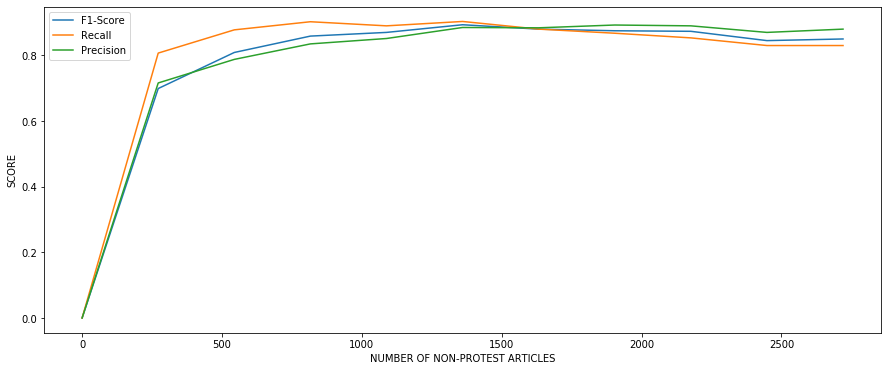

In [159]:
plt.figure(figsize=(15,6))
plt.plot(cls0_steps,[stat.mean(i) for i in svm_testr0['f']],label="F1-Score")
plt.plot(cls0_steps,[stat.mean(i) for i in svm_testr0['r']],label="Recall")
plt.plot(cls0_steps,[stat.mean(i) for i in svm_testr0['p']],label="Precision")
plt.ylabel('SCORE')
plt.xlabel('NUMBER OF NON-PROTEST ARTICLES')
plt.legend()
plt.show()

In [160]:
svm_testr0['p'][-1].append(svm_testr0['p'][-1][0])
svm_testr0['f'][-1].append(svm_testr0['f'][-1][0])
svm_testr0['r'][-1].append(svm_testr0['r'][-1][0])

In [161]:
pd.DataFrame([[cls0_steps[s],stat.mean(svm_testr0['f'][s]),
 stat.stdev(svm_testr0['f'][s])] 
 for s in range(len(svm_testr0['f']))],columns=['Sample Size','Avg F1-Score','F1-Score Std Dev.'])

,Sample Size,Avg F1-Score,F1-Score Std Dev.
0,0,0.000000,0.000000
1,272,0.699000,0.025144
2,544,0.808889,0.015366
3,816,0.858750,0.011260
4,1088,0.870000,0.010000
5,1360,0.893333,0.005164
6,1632,0.880000,0.023452
7,1904,0.875000,0.017321
8,2176,0.873333,0.011547
9,2448,0.845000,0.007071


In [162]:
pd.DataFrame([[cls0_steps[s],stat.mean(svm_testr0['p'][s]),
 stat.stdev(svm_testr0['p'][s])] 
 for s in range(len(svm_testr0['p']))],columns=['Sample Size','Avg. Precision','Precision Std Dev.'])

,Sample Size,Avg. Precision,Precision Std Dev.
0,0,0.000000,0.000000
1,272,0.716000,0.011738
2,544,0.787778,0.009718
3,816,0.835000,0.007559
4,1088,0.851429,0.012150
5,1360,0.885000,0.005477
6,1632,0.884000,0.027019
7,1904,0.892500,0.022174
8,2176,0.890000,0.010000
9,2448,0.870000,0.000000


In [163]:
pd.DataFrame([[cls0_steps[s],stat.mean(svm_testr0['r'][s]),
 stat.stdev(svm_testr0['r'][s])] 
 for s in range(len(svm_testr0['r']))],columns=['Sample Size','Avg. Recall','Recall Std Dev.'])

,Sample Size,Avg. Recall,Recall Std Dev.
0,0,0.000000,0.000000
1,272,0.807000,0.017670
2,544,0.877778,0.009718
3,816,0.902500,0.007071
4,1088,0.890000,0.008165
5,1360,0.903333,0.010328
6,1632,0.880000,0.020000
7,1904,0.867500,0.012583
8,2176,0.853333,0.015275
9,2448,0.830000,0.000000


## Class 1

### Dev

In [164]:
svm1_steps = list(range(round(train[train.label == 1.0].shape[0]/8),
                   train[train.label == 1.0].shape[0],
                   round(train[train.label == 1.0].shape[0]/8)))
svm1_steps.append(train[train.label == 1.0].shape[0])
svm1_steps.insert(0,0)

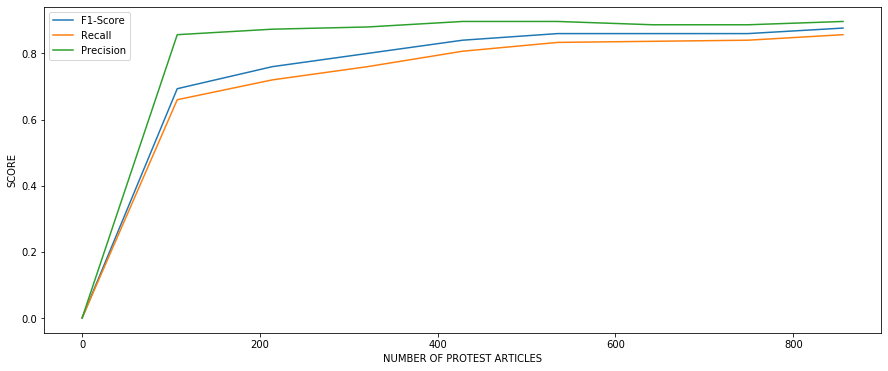

In [165]:
plt.figure(figsize=(15,6))
plt.plot(svm1_steps,[stat.mean(i) for i in svm_devr1['f']],label="F1-Score")
plt.plot(svm1_steps,[stat.mean(i) for i in svm_devr1['r']],label="Recall")
plt.plot(svm1_steps,[stat.mean(i) for i in svm_devr1['p']],label="Precision")
plt.ylabel('SCORE')
plt.xlabel('NUMBER OF PROTEST ARTICLES')
plt.legend()
plt.show()

In [166]:
pd.DataFrame([[svm1_steps[s],stat.mean(svm_devr1['f'][s]),
 stat.stdev(svm_devr1['f'][s])] 
 for s in range(len(svm_testr1['f']))],columns=['Sample Size','Avg F1-Score','F1-Score Std Dev.'])

,Sample Size,Avg F1-Score,F1-Score Std Dev.
0,0,0.000000,0.000000
1,107,0.693333,0.023094
2,214,0.760000,0.036056
3,321,0.800000,0.020000
4,428,0.840000,0.010000
5,535,0.860000,0.010000
6,642,0.860000,0.000000
7,749,0.860000,0.010000
8,856,0.876667,0.005774


In [167]:
pd.DataFrame([[svm1_steps[s],stat.mean(svm_devr1['p'][s]),
 stat.stdev(svm_devr1['p'][s])] 
 for s in range(len(svm_devr1['p']))],columns=['Sample Size','Avg. Precision','Precision Std Dev.'])

,Sample Size,Avg. Precision,Precision Std Dev.
0,0,0.000000,0.000000
1,107,0.856667,0.032146
2,214,0.873333,0.023094
3,321,0.880000,0.036056
4,428,0.896667,0.005774
5,535,0.896667,0.005774
6,642,0.886667,0.005774
7,749,0.886667,0.005774
8,856,0.896667,0.005774


In [168]:
pd.DataFrame([[svm1_steps[s],stat.mean(svm_devr1['r'][s]),
 stat.stdev(svm_devr1['r'][s])] 
 for s in range(len(svm_devr1['r']))],columns=['Sample Size','Avg. Recall','Recall Std Dev.'])

,Sample Size,Avg. Recall,Recall Std Dev.
0,0,0.000000,0.000000
1,107,0.660000,0.017321
2,214,0.720000,0.034641
3,321,0.760000,0.026458
4,428,0.806667,0.011547
5,535,0.833333,0.005774
6,642,0.836667,0.005774
7,749,0.840000,0.010000
8,856,0.856667,0.005774


### Test

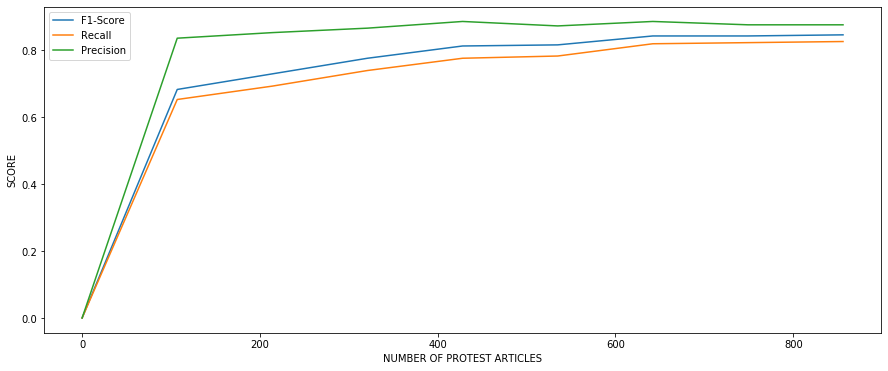

In [169]:
plt.figure(figsize=(15,6))
plt.plot(svm1_steps,[stat.mean(i) for i in svm_testr1['f']],label="F1-Score")
plt.plot(svm1_steps,[stat.mean(i) for i in svm_testr1['r']],label="Recall")
plt.plot(svm1_steps,[stat.mean(i) for i in svm_testr1['p']],label="Precision")
plt.ylabel('SCORE')
plt.xlabel('NUMBER OF PROTEST ARTICLES')
plt.legend()
plt.show()

In [170]:
pd.DataFrame([[svm1_steps[s],stat.mean(svm_testr1['f'][s]),
 stat.stdev(svm_testr1['f'][s])] 
 for s in range(len(svm_testr1['f']))],columns=['Sample Size','Avg F1-Score','F1-Score Std Dev.'])

,Sample Size,Avg F1-Score,F1-Score Std Dev.
0,0,0.000000,0.000000
1,107,0.683333,0.030551
2,214,0.730000,0.036056
3,321,0.776667,0.023094
4,428,0.813333,0.005774
5,535,0.816667,0.005774
6,642,0.843333,0.005774
7,749,0.843333,0.011547
8,856,0.846667,0.005774


In [171]:
pd.DataFrame([[svm1_steps[s],stat.mean(svm_testr1['p'][s]),
 stat.stdev(svm_testr1['p'][s])] 
 for s in range(len(svm_testr1['p']))],columns=['Sample Size','Avg. Precision','Precision Std Dev.'])

,Sample Size,Avg. Precision,Precision Std Dev.
0,0,0.000000,0.000000
1,107,0.836667,0.032146
2,214,0.853333,0.023094
3,321,0.866667,0.032146
4,428,0.886667,0.011547
5,535,0.873333,0.011547
6,642,0.886667,0.005774
7,749,0.876667,0.005774
8,856,0.876667,0.005774


In [172]:
pd.DataFrame([[svm1_steps[s],stat.mean(svm_testr1['r'][s]),
 stat.stdev(svm_testr1['r'][s])] 
 for s in range(len(svm_testr1['r']))],columns=['Sample Size','Avg. Recall','Recall Std Dev.'])

,Sample Size,Avg. Recall,Recall Std Dev.
0,0,0.000000,0.000000
1,107,0.653333,0.020817
2,214,0.693333,0.028868
3,321,0.740000,0.017321
4,428,0.776667,0.005774
5,535,0.783333,0.005774
6,642,0.820000,0.010000
7,749,0.823333,0.011547
8,856,0.826667,0.005774


# Collection of Results [Grouped Graphs]

## Gaussian

### Dev

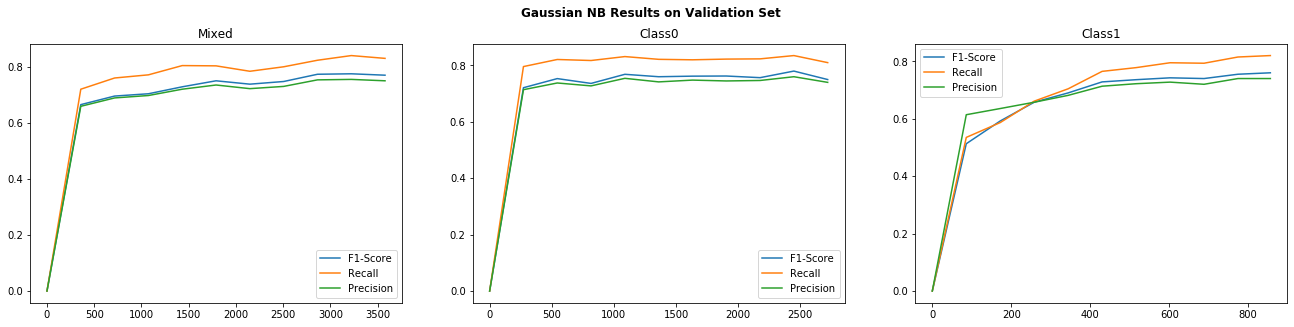

In [179]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(19,5),sharey=False)
fig.suptitle('Gaussian NB Results on Validation Set',fontweight='bold')
fig.tight_layout(pad=4)

ax1.plot(mix_steps,[stat.mean(i) for i in gnb_devr['f']],label="F1-Score")
ax1.plot(mix_steps,[stat.mean(i) for i in gnb_devr['r']],label="Recall")
ax1.plot(mix_steps,[stat.mean(i) for i in gnb_devr['p']],label="Precision")
ax1.set_title('Mixed')
ax1.legend()

ax2.plot(cls0_steps,[stat.mean(i) for i in gnb_devr0['f']],label="F1-Score")
ax2.plot(cls0_steps,[stat.mean(i) for i in gnb_devr0['r']],label="Recall")
ax2.plot(cls0_steps,[stat.mean(i) for i in gnb_devr0['p']],label="Precision")
ax2.set_title('Class0')
ax2.legend()

ax3.plot(cls1_steps,[stat.mean(i) for i in gnb_devr1['f']],label="F1-Score")
ax3.plot(cls1_steps,[stat.mean(i) for i in gnb_devr1['r']],label="Recall")
ax3.plot(cls1_steps,[stat.mean(i) for i in gnb_devr1['p']],label="Precision")
ax3.set_title('Class1')
ax3.legend()

### Test

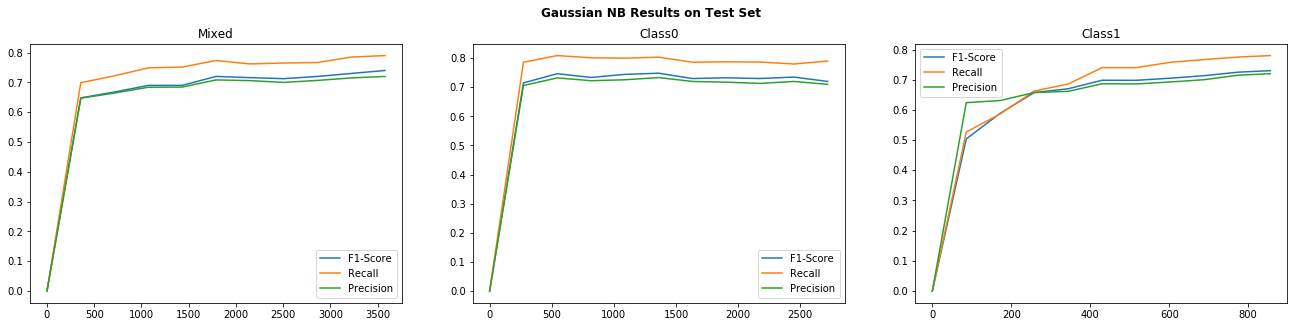

In [174]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(19,5),sharey=False)
fig.suptitle('Gaussian NB Results on Test Set',fontweight='bold')
fig.tight_layout(pad=4)

ax1.plot(mix_steps,[stat.mean(i) for i in gnb_testr['f']],label="F1-Score")
ax1.plot(mix_steps,[stat.mean(i) for i in gnb_testr['r']],label="Recall")
ax1.plot(mix_steps,[stat.mean(i) for i in gnb_testr['p']],label="Precision")
ax1.set_title('Mixed')
ax1.legend()

ax2.plot(cls0_steps,[stat.mean(i) for i in gnb_testr0['f']],label="F1-Score")
ax2.plot(cls0_steps,[stat.mean(i) for i in gnb_testr0['r']],label="Recall")
ax2.plot(cls0_steps,[stat.mean(i) for i in gnb_testr0['p']],label="Precision")
ax2.set_title('Class0')
ax2.legend()

ax3.plot(cls1_steps,[stat.mean(i) for i in gnb_testr1['f']],label="F1-Score")
ax3.plot(cls1_steps,[stat.mean(i) for i in gnb_testr1['r']],label="Recall")
ax3.plot(cls1_steps,[stat.mean(i) for i in gnb_testr1['p']],label="Precision")
ax3.set_title('Class1')
ax3.legend()

## SVM

### Dev

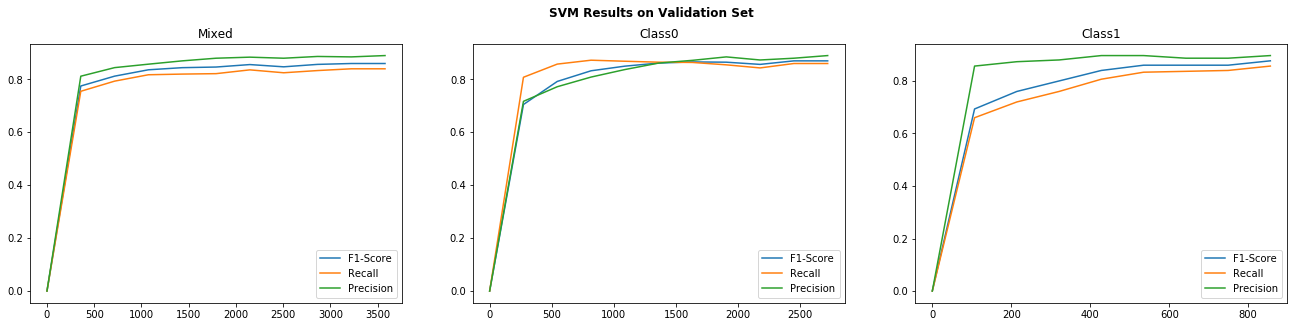

In [175]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(19,5),sharey=False)
fig.suptitle('SVM Results on Validation Set',fontweight='bold')
fig.tight_layout(pad=4)

ax1.plot(mix_steps,[stat.mean(i) for i in svm_devr['f']],label="F1-Score")
ax1.plot(mix_steps,[stat.mean(i) for i in svm_devr['r']],label="Recall")
ax1.plot(mix_steps,[stat.mean(i) for i in svm_devr['p']],label="Precision")
ax1.set_title('Mixed')
ax1.legend()

ax2.plot(cls0_steps,[stat.mean(i) for i in svm_devr0['f']],label="F1-Score")
ax2.plot(cls0_steps,[stat.mean(i) for i in svm_devr0['r']],label="Recall")
ax2.plot(cls0_steps,[stat.mean(i) for i in svm_devr0['p']],label="Precision")
ax2.set_title('Class0')
ax2.legend()

ax3.plot(svm1_steps,[stat.mean(i) for i in svm_devr1['f']],label="F1-Score")
ax3.plot(svm1_steps,[stat.mean(i) for i in svm_devr1['r']],label="Recall")
ax3.plot(svm1_steps,[stat.mean(i) for i in svm_devr1['p']],label="Precision")
ax3.set_title('Class1')
ax3.legend()

### Test

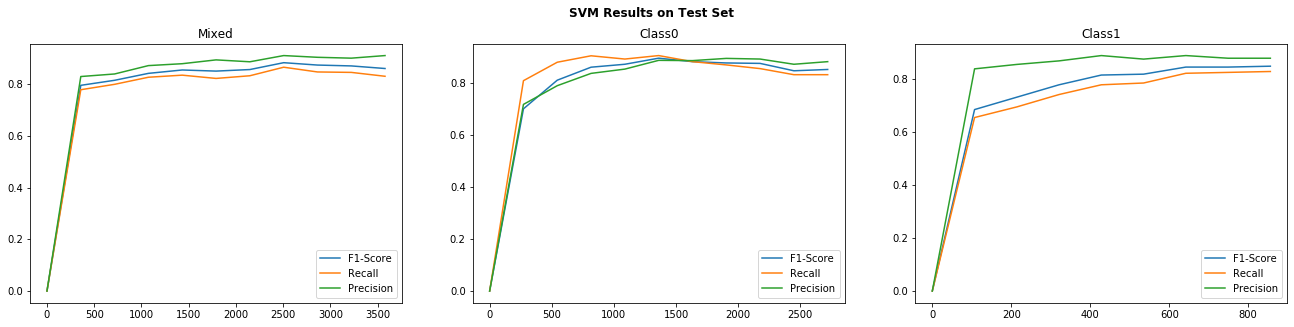

In [176]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(19,5),sharey=False)
fig.suptitle('SVM Results on Test Set',fontweight='bold')
fig.tight_layout(pad=4)

ax1.plot(mix_steps,[stat.mean(i) for i in svm_testr['f']],label="F1-Score")
ax1.plot(mix_steps,[stat.mean(i) for i in svm_testr['r']],label="Recall")
ax1.plot(mix_steps,[stat.mean(i) for i in svm_testr['p']],label="Precision")
ax1.set_title('Mixed')
ax1.legend()

ax2.plot(cls0_steps,[stat.mean(i) for i in svm_testr0['f']],label="F1-Score")
ax2.plot(cls0_steps,[stat.mean(i) for i in svm_testr0['r']],label="Recall")
ax2.plot(cls0_steps,[stat.mean(i) for i in svm_testr0['p']],label="Precision")
ax2.set_title('Class0')
ax2.legend()

ax3.plot(svm1_steps,[stat.mean(i) for i in svm_testr1['f']],label="F1-Score")
ax3.plot(svm1_steps,[stat.mean(i) for i in svm_testr1['r']],label="Recall")
ax3.plot(svm1_steps,[stat.mean(i) for i in svm_testr1['p']],label="Precision")
ax3.set_title('Class1')
ax3.legend()

## MLP

### Dev

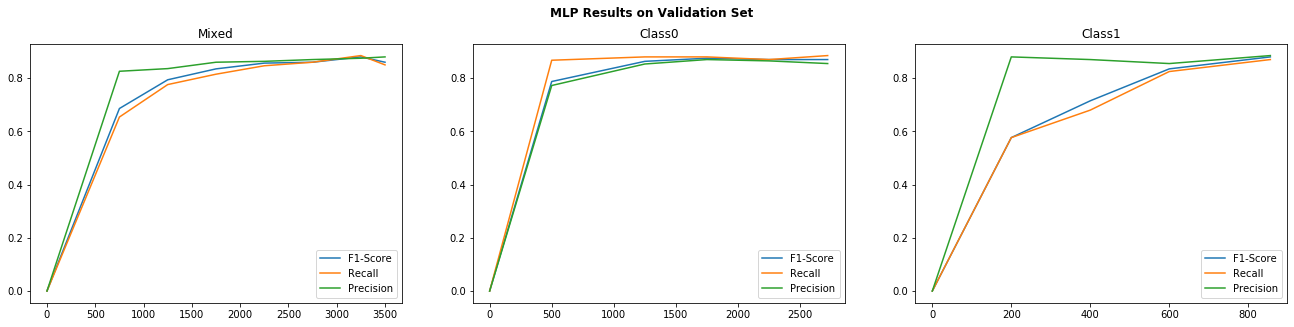

In [177]:
import statistics as stats
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(19,5),sharey=False)
fig.suptitle('MLP Results on Validation Set',fontweight='bold')
fig.tight_layout(pad=4)

ax1.plot(mlp_mixed_steps,[0]+[stats.mean([j[0][2] for j in i]) for i in mlp_mixed],label="F1-Score")
ax1.plot(mlp_mixed_steps,[0]+[stats.mean([j[0][0] for j in i]) for i in mlp_mixed],label="Recall")
ax1.plot(mlp_mixed_steps,[0]+[stats.mean([j[0][1] for j in i]) for i in mlp_mixed],label="Precision")
ax1.set_title('Mixed')
ax1.legend()

ax2.plot(mlp_class0_steps,[0]+[stats.mean([j[0][2] for j in i]) for i in mlp_class0],label="F1-Score")
ax2.plot(mlp_class0_steps,[0]+[stats.mean([j[0][0] for j in i]) for i in mlp_class0],label="Recall")
ax2.plot(mlp_class0_steps,[0]+[stats.mean([j[0][1] for j in i]) for i in mlp_class0],label="Precision")
ax2.set_title('Class0')
ax2.legend()

ax3.plot(mlp_class1_steps,[0]+[stats.mean([j[0][2] for j in i]) for i in mlp_class1],label="F1-Score")
ax3.plot(mlp_class1_steps,[0]+[stats.mean([j[0][0] for j in i]) for i in mlp_class1],label="Recall")
ax3.plot(mlp_class1_steps,[0]+[stats.mean([j[0][1] for j in i]) for i in mlp_class1],label="Precision")
ax3.set_title('Class1')
ax3.legend()

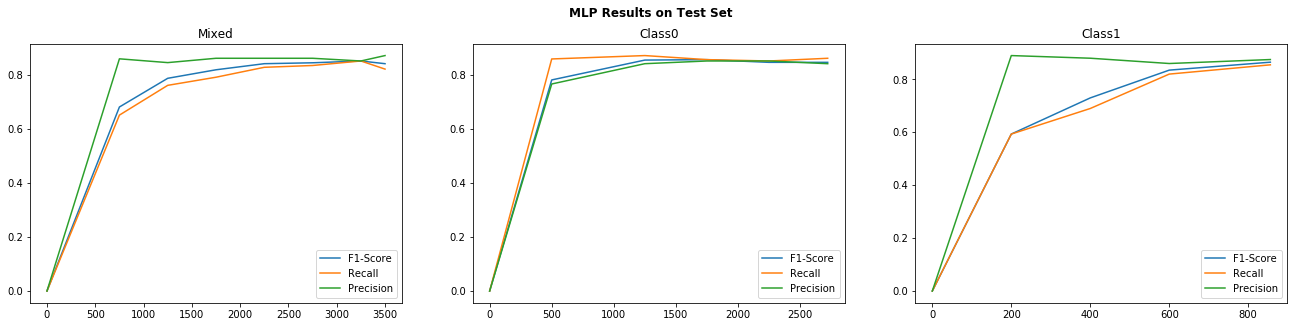

In [178]:
import statistics as stats
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(19,5),sharey=False)
fig.suptitle('MLP Results on Test Set',fontweight='bold')
fig.tight_layout(pad=4)

ax1.plot(mlp_mixed_steps,[0]+[stats.mean([j[1][2] for j in i]) for i in mlp_mixed],label="F1-Score")
ax1.plot(mlp_mixed_steps,[0]+[stats.mean([j[1][0] for j in i]) for i in mlp_mixed],label="Recall")
ax1.plot(mlp_mixed_steps,[0]+[stats.mean([j[1][1] for j in i]) for i in mlp_mixed],label="Precision")
ax1.set_title('Mixed')
ax1.legend()

ax2.plot(mlp_class0_steps,[0]+[stats.mean([j[1][2] for j in i]) for i in mlp_class0],label="F1-Score")
ax2.plot(mlp_class0_steps,[0]+[stats.mean([j[1][0] for j in i]) for i in mlp_class0],label="Recall")
ax2.plot(mlp_class0_steps,[0]+[stats.mean([j[1][1] for j in i]) for i in mlp_class0],label="Precision")
ax2.set_title('Class0')
ax2.legend()

ax3.plot(mlp_class1_steps,[0]+[stats.mean([j[1][2] for j in i]) for i in mlp_class1],label="F1-Score")
ax3.plot(mlp_class1_steps,[0]+[stats.mean([j[1][0] for j in i]) for i in mlp_class1],label="Recall")
ax3.plot(mlp_class1_steps,[0]+[stats.mean([j[1][1] for j in i]) for i in mlp_class1],label="Precision")
ax3.set_title('Class1')
ax3.legend()